In [ ]:
# default_exp noncontextual_bandits

# noncontextual_bandits
> example of noncontextual bandits

# Intro



The aim of this notebook is to provide a low tech overview over MAB solvers, specifically A/B testing and Thompson Sampler. Others such as Epsilon Greedy and UCB MIGHT follow, but since TS is relatively undisputed when it comes to decision making for a couple of reasons, this might not happen.

We will first look at the problem at hand, the Multi Armed Bandit and how we can emulate an environment that houses one. Then we turn towards the classical solution to MABs: A/B testing. Through the evaluation of some of it's weaknesses stemming from the distinction between exploration and exploitation phase, we will arrive at a theoretical construct that already almost resembles Thompson Sampling, from where it is an easy jump to the full thing.

![alt](https://miro.medium.com/max/1596/1*EnNqxjvgYcgP3qcvceEeHg.jpeg)
<sub><sup>(from https://miro.medium.com/max/1596/1*EnNqxjvgYcgP3qcvceEeHg.jpeg)</sup></sub>



This notebook is aimed at people looking to apply TS with a working understanding of what it does but foregoes the mathematical descriptions and proofs necessary to argue for TS in an academic setting. 

Note that we're focussing on the simplest use case imaginable, which means we can use simple beta-binomial distribution to compute our thompson sampling. This is does little more than elaborate counting AND STILL it is useful for outshining A/B tests in a categorical case. 

Note also that we stripped anything complex from the notebook to focus on the underlying concepts rather than, say, computing how many people we need in our groups to get statistically significant (a concept we're also ignoring because... Bayes Rule(s)!).

# What is a multi armed bandit situation?

In the multi armed bandit setting, we are tasked with finding the best performing action out of a selection of possible actions. An example could be the color of a button on a website. We could make it Blue or Yellow. Our theories are that Blue is easier to see but Yellow is a more inviting color. We now have to figure out which of these effects is stronger, i.e. which button color gets clicked more often(1).


We do not know which theory is correct, and, unfortunately, we will never KNOW which button is better, since for that we'd need to know what would have happened if the users that saw yellow were presented with blue and vice versa, for all eternity. Maybe the users that saw it so far preferred yellow because it was summer. Or the background of an ad that popped up made it very hard to see the blue button. 
This is, in essence, what we refer to as the dilemma of 'Exploration vs Exploitation': Do we rely on the information we have available to make a decision or do we want to collect more data so that our future decisions will be a better informed one?

![alt](http://www.primarydigit.com/uploads/2/0/1/6/20168087/2155136.png?387)
<sub><sup>(from http://www.primarydigit.com/uploads/2/0/1/6/20168087/2155136.png?387)</sup></sub>

In this Notebook, we want to look at a few possible solutions to this problem.


# How do we test these approaches

To do so, we need to simulate a situation in which a customer makes a choice we do not know up front, since we don't have actual customers to ask. To do that, we generate an 'average customer'. This average customer is going to react to the color of the button with probabilities proportional to how the real population MIGHT react (this is of course simulated). This value is stored in our variable 'Theta'; it reflects how likely the general population is to click on a blue vs a yellow button. We convert this probability to a reaction by sampling a number between 0 and 1 and comparing it to the theta value for that choice, see customer_reaction().




 (1) This is not a real life situation, in which we might take into account different additional parameters such as page background - which we'd optimally test, too.

In [ ]:
import numpy as np

In [ ]:
from thompson_sampling.helpers import showcase_code

In [ ]:
from thompson_sampling.multi_armed_bandits import non_contextual_categorical_bandit

In [ ]:
showcase_code('thompson_sampling/multi_armed_bandits.py',method_name = 'non_contextual_categorical_bandit')

In [ ]:
theta = [0.2,0.8]

In [ ]:


mean_0 = np.mean([non_contextual_categorical_bandit(0, theta) for i in range(10)])
mean_1 = np.mean([non_contextual_categorical_bandit(1, theta) for i in range(10)])
print(f'empirical mean for choice 0 is {mean_0} (real value {theta[0]}), is {mean_1} (real value {theta[1]}) for choice 1')



empirical mean for choice 0 is 0.4 (real value 0.2), is 0.9 (real value 0.8) for choice 1


# Now that the problem is defined, let's solve it

I will introduce two approaches, A/B testing and Thompson Sampling in detail and mention two others, epsilpon greedy and UCB, in passing.
But first, let's quickly introduce our general strategy:

## Abstract solution to Bandit Problems

In order to solve the problem posed above, we devise a simple black box strategy: 
We will build a system that chooses an arm (in our example, blue or yellow button) by some policy  and updates that policy based on what it observes (in our example: did the user click). This policy will be chosen to solve our exploration vs exploitation dilemma in some way.

Note that this is very general. On the one hand, this approach can house an ideterminate number of policies such as A/B testing, Thompson Sampler, ... ; on the other hand, this can be extended to many other problems solvable with reinforcement learning. 

Again, all we do in MAB problems is choose an action that seems favorable given an internal policy and update that policy given the reward our action produced.




In [ ]:
showcase_code('thompson_sampling/abstractions.py',class_name = 'AbstractSolver')


## A/B Test
A/B tests are the current standard for solving multi armed bandit dilemmas. They are being used in all kinds of situations and are very closely related to the gold standard of scientific experimentation.
The concept is simple and clear:

We split our users in two equal groups randomly and show them different options for a pre-determined number of trials - and then we decide to go with one of the options for the rest of the time. 
Note he explicit split into Exploration phase in which we randomly show different arms to observe the reward and the Exploitation phase in which we always play the arm that performed best during the exploration.

In reality, there are a few complex additions to how to condut an A/B test properly, like estimating the expected effect size and deciding beforehand how strong the difference in groups has to be for it to be considered valid, and that in turn is used to compute the sample size and... All these problems arise, because classical A/B tests are 'Frequentist' (named after people who believe that probabilities are closely related to frequencies - but: different topic) and thus we need to be careful not to screw up the decision process. We will ignore those extra points for the sake of clarity(2).

Below we implement an A/B test.




(2)If you're interested, these seem like two good resources to start: 
- https://towardsdatascience.com/the-art-of-a-b-testing-5a10c9bb70a4
- https://blog.hubspot.com/marketing/how-to-do-a-b-testing

In [ ]:
from thompson_sampling.solvers import AB, BetaBandit

# uncomment this if you're interested in seein the AB test code
showcase_code('thompson_sampling/solvers.py',class_name = 'AB')

In [ ]:
ab = AB(n_experiments=100)

print(np.mean([ab.choose_arm() for x in range(10000)]))
ab.update(1,1)
print(np.mean([ab.choose_arm() for x in range(10000)])
)

0.5023
0.4985


as we can see, an update does not change the outcome of the AB test, as long as we're below the number of experiments that we chose upfront.

In [ ]:
for i in range(101):
    arm = ab.choose_arm()
    reward = non_contextual_categorical_bandit(arm,theta=theta)
    ab.update(arm,reward)

now, let's see what happens after we observed the required number of outcomes:

In [ ]:
print(np.mean([ab.choose_arm() for x in range(10000)]))
ab.update(1,1)
print(np.mean([ab.choose_arm() for x in range(10000)])
)

1.0
1.0


As we can see, after the experiment is finished - during exploitation - the AB test will always play the arm it found to be best during the exploration time. This has a few implications, such as being stuck with the decision, independently on whether the customer's behaviour changed or we made a mistake getting it in the first place. If we want to choose differently, we need to set up a new experiment.

## Thompson Sampler

AB testing has a few drawbacks:

What do we do if the difference in our sample isn't large enough to confidently say one is better after the experiment was concluded?

What if we chose the number of people we're testing wrong and now instead of using the awesome blue button that seems to perform so much better we are now stuck with showing half of the users the ugly yellow one?! we're good scientists so we won't interrupt the experiment; if we're REALLY good scientist we won't even peek so we DON'T KNOW THAT OUR USERS ARE BEING LED ASTRAY BY OUR EVIL AMBER!

What if we realize that we performed our experiment during a time in which, for some reason, the users were not reacting as usually, maybe because everyone is acting irrationally and buying too much toilet paper? NOW WE ARE STUCK WITH THAT DASTARDLY DANDELLION BUTTON!

...What if we realize that we actually want to test a red button, too? WAAAAAAAAH!!!!!!!!


All these problems arise because we decided to have a clear distinction between exploration and exploitation. First we randomly sample user experiences so we can find out which one works better and then we stick to whatever comes out of that.
This leads to us being stuck the phase in which we either collect data from a random process we can't influence or the phase in which we use that information to ~~generate moneyz~~ make sure we offer our users an optimal experience, without being able to incorporate new evidence.

Wouldn't it be great if we could do both at the same time? Maybe by **updating the sampling scheme** used during the exploration so it doesn't just return either arm half the time but **increases the chance of seing the button that has been performing better in the past** each time we see it perform better? Wouldn't it be great if we could do that until the end of times because we do not need to decide when to stop the experiment because inherently, the best arm gets played most of the time anyways?

Yes that would be great. And we're doing it. It's called Thompson Sampling. 









Thompson Sampling was invented in 1933 and has been rediscovered a bunch of times since then (source: Wikipedia) because it is so fantastic. 
It is an inherently Bayesian approach (compared to 'Frequentist' from earlier), which for all intents and purposes means it operates on Probability Distributions rather than point estimates and uses something called a 'Prior'. For deeper discussions, feel free to hit me up on Slack :) 


![alt](https://image.slidesharecdn.com/atackingthemulti-armed-bandit-problem-slides-190517222554/95/claudia-vicol-solving-the-multi-armed-bandit-problem-codemotion-amsterdam-2019-18-638.jpg?cb=1558132137)
<sub><sup>(from https://image.slidesharecdn.com/atackingthemulti-armed-bandit-problem-slides-190517222554/95/claudia-vicol-solving-the-multi-armed-bandit-problem-codemotion-amsterdam-2019-18-638.jpg?cb=1558132137)</sup></sub>



Our implementation relies on two methods, again:

Choose_arm, which 
*** for each arm draws from the distribution over the expected rewards*** (this will become easier to understand with the visualisations below!) and compares them to see which one is higher. This is where the 'constant exploration' is: even with very different distributions, sampling will *occasionally* allow for all arms to be played. 

The Update arm, which observes the reward after playing an arm and updates the distribution of that arm to reflect the new knowledge. This means two things: The distribution will get narrower (unless we have very diverging data) and its mean will move closer to what the model thinks the expected reward of an arm is. 

If we look back at the choose arm now - a narrower distribution translates into a narrower spread of likely values to be drawn from that distribution. This means - as the Thompson Sampler converges, each arms' sample will get more likely to be around a certain value - and thus the one with the higher expectation will be played more than the others.


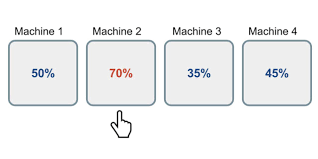

This means, while we managed to get rid of distinct exploration vs exploitation phases, we have a continuous shift from one to the other, meaning we're going to start exploiting more just as we have enough data to do so. 

Let's see what that looks like.

In [ ]:
showcase_code('thompson_sampling/solvers.py','BetaBandit', end_string=True)

In [ ]:
bb = BetaBandit()


In [ ]:
np.mean([bb.choose_arm() for x in range(100)])

0.5

0

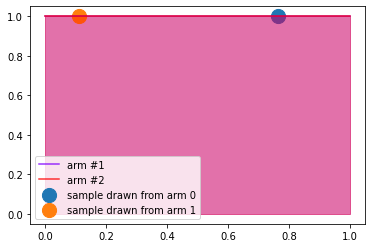

In [ ]:
bb.choose_arm_and_plot() #uniform binomials, no observations yet

In [ ]:
bb.update(0,0)
bb.update(0,1)
bb.update(0,1)

In [ ]:
np.mean([bb.choose_arm() for x in range(100)])

0.07

1

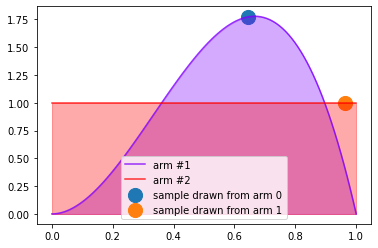

In [ ]:
bb.choose_arm_and_plot() #uniform binomials, no observations yet

In [ ]:
bb.update(1,0)
bb.update(1,0)
bb.update(1,0)

In [ ]:
np.mean([bb.choose_arm() for x in range(100)])

0.08

0

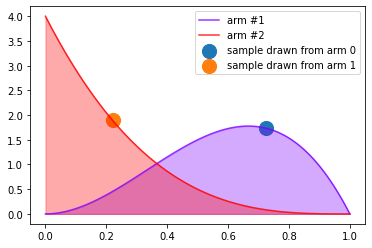

In [ ]:
bb.choose_arm_and_plot() #uniform binomials, no observations yet

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

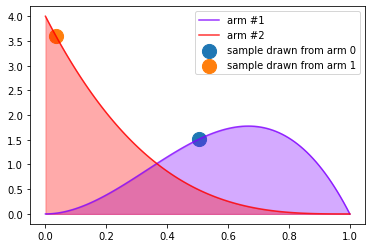

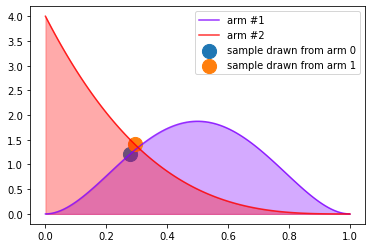

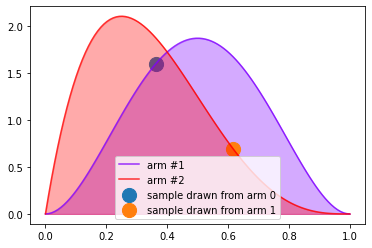

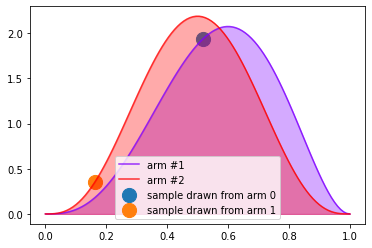

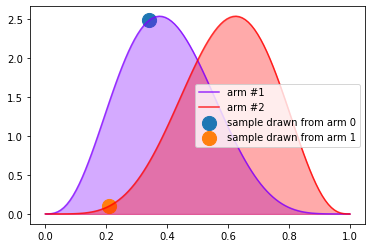

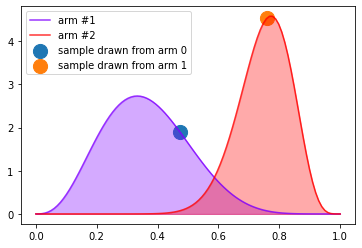

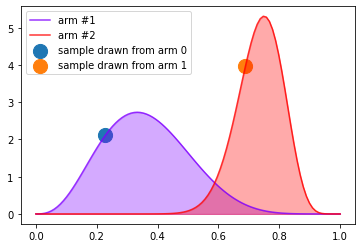

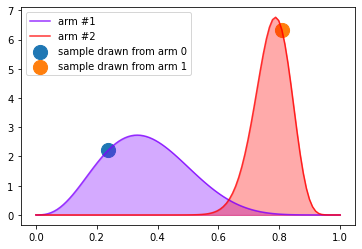

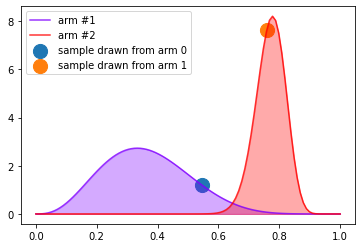

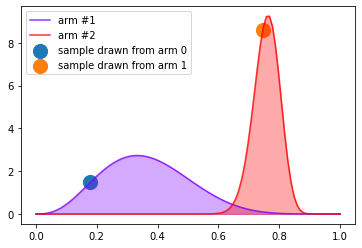

In [ ]:
for i in range(250):
  if i in [0,1,2,5,10,25,35,50,75,100,250]:
    plt.figure()
    arm = bb.choose_arm_and_plot()
  else:
    arm = bb.choose_arm()
  reward = non_contextual_categorical_bandit(arm,theta=theta)
  bb.update(arm,reward)


# Evaluating AB test and Thompson Sampler

To test the performance of Our models, we need to introduce two concepts: the virtual customer, a program that makes probabilistic decisions based on values we might see in the real world,
and regret. 
Regret is the mathematical notion of 'what would have happened had I always chosen perfectly', and I'm sure most of you understand that concept on a carnal level.

In [ ]:
def run_experiment(app, num_experiments,theta):
    best_arm = np.argmax(theta)
    
    arms = []
    outcomes = []
    
    for i in range(num_experiments):
        
        arm = app.choose_arm()
        arms += [arm]
        outcome = non_contextual_categorical_bandit(arm, theta=theta)
        outcomes += [outcome]
        app.update(arm,outcome)
        
    regret = np.sum(np.ones(shape=(num_experiments,))*theta[best_arm]- outcomes )
    cumulative_regret = np.cumsum( np.ones(shape=(num_experiments,))*theta[best_arm] -outcomes )


    return regret, cumulative_regret

In [ ]:
def plot_cumulative_regret(cumulative_regret,app):
  plt.plot(cumulative_regret,label='regret')#is_conversion(best_arm,_bool=False)))
  plt.title(str(type(app)))
  leg = plt.legend()
  plt.tight_layout()
  plt.show()

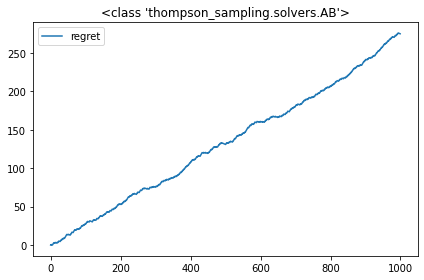

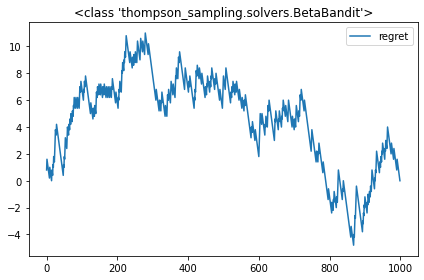

In [ ]:
ab = AB()
bb = BetaBandit()

for app in [ab,bb]:
  regret, cumulative_regret = run_experiment(app,num_experiments=1000,theta=theta)
  plot_cumulative_regret(cumulative_regret, app)

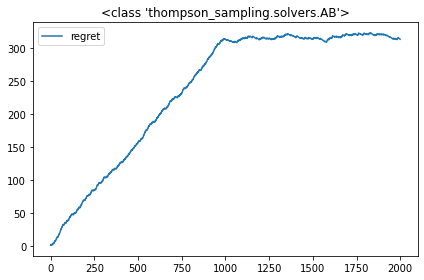

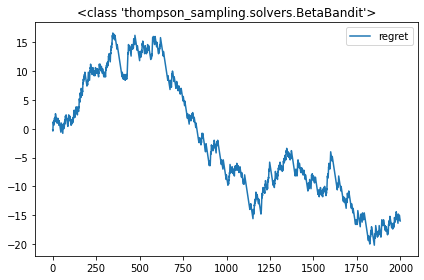

In [ ]:
ab = AB()
bb = BetaBandit()

for app in [ab,bb]:
  regret, cumulative_regret = run_experiment(app,num_experiments=2000, theta= theta)
  plot_cumulative_regret(cumulative_regret, app)

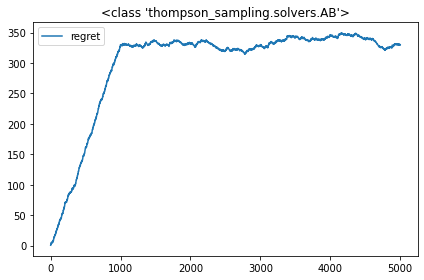

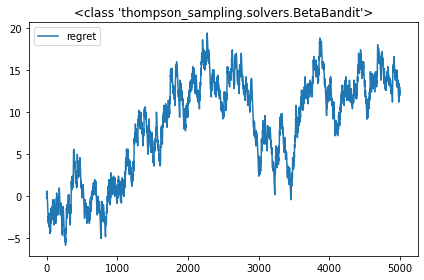

In [ ]:
ab = AB()
bb = BetaBandit()

for app in [ab,bb]:
  regret, cumulative_regret = run_experiment(app,num_experiments=5000, theta = theta)
  plot_cumulative_regret(cumulative_regret, app)

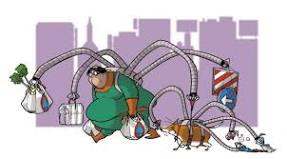

(from <sub><sup>https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.listal.com%2Flist%2Fhow-fairy-tales-really-end&psig=AOvVaw3k15RE2dHJCYFOgr8ikTzx&ust=1587374290515000&source=images&cd=vfe&ved=0CAIQjRxqFwoTCOjtrJmU9OgCFQAAAAAdAAAAABAM </sup></sub>)